# simplest FFT-based hologram test run

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def hologram(url):
    #make an image array from the given image
    img = cv2.imread(url, 0)            #importing the image in grayscale and turning it into an array

    #determine the dimension of the image
    M = img.shape[0]                    #Width of the image
    N = img.shape[1]                    #Height of the image

    #formation of the object wave
    objectFourier = np.fft.fft2(img)                                   #Far field amplitude of the object wave
    shiftObject = np.fft.fftshift(objectFourier)                       #shifting the whites to the center
    objectWave = np.abs(shiftObject) * np.abs(shiftObject)             #absolute value of the image

    magnitude_spectrum = 20 * np.log(objectWave)                       #obtain the magnitude spectrum

    #formation of the reference wave
    reference = np.zeros((M, N))                                        #creating an array and filling it with zeros

    T1 = M / 2                                                          #finding the mid point
    T1 = T1 + 1                                                         #finding the mid point
    T2 = N / 2
    T2 = T2 + 1

    reference[int(T1), int(T2)] = 100                                              #illuminate a point in the reference array

    referenceFourier = np.fft.fft2(reference)                            #applying Fast Fourier on the reference wave array
    referenceShift = np.fft.fftshift(referenceFourier)
    referenceWave = np.abs(referenceShift) * np.abs(referenceShift)

    # adding both the waves
    superpositionWave = shiftObject + referenceShift                                  #superposition of the waves
    superpositionedFinalWave = np.abs(superpositionWave) * np.abs(superpositionWave)
    hologram = superpositionedFinalWave - objectWave                                  #final interference pattern

    # reconstruction
    reconstructedWave = np.fft.fft2(hologram)
    reconstructShift = np.fft.fftshift(reconstructedWave)
    finalReconstruction = np.abs(reconstructShift) * np.abs(reconstructShift)        #RECONSTRUCTED image

    # plotting
    plt.subplot(231), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(232), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.subplot(233), plt.imshow(objectWave, cmap='hot')
    plt.title('Object'), plt.xticks([]), plt.yticks([])
    plt.subplot(234), plt.imshow(referenceWave, cmap='gray')
    plt.title('Ref'), plt.xticks([]), plt.yticks([])
    plt.subplot(235), plt.imshow(hologram, cmap='gray')
    plt.title('Without filtering'), plt.xticks([]), plt.yticks([])
    plt.subplot(236), plt.imshow(finalReconstruction, cmap='gray')
    plt.title('Reconstructed image'), plt.xticks([]), plt.yticks([])
    plt.show()

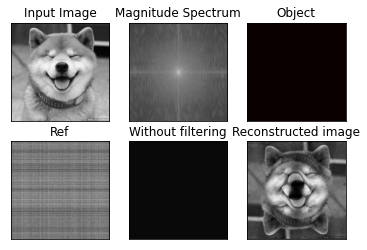

In [2]:
hologram('test.jpeg')

In [1]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from multiplane import *

In [4]:
# test point cloud
# points = np.random.rand(20,3)
points = np.asarray(o3d.io.read_point_cloud("data/bunny_pc.ply").points)
print(points.shape)
showGeometry(points)

# mesh = o3d.io.read_triangle_mesh("xyzrgb_dragon.obj")
# o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

(500000, 3)
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


In [4]:
a, dz = multiplePlane(points, 5, sort_by_plane=False)

In [5]:
np.unique(dz)

array([0, 1, 2, 3, 4, 5])

In [6]:
a[0] # x y z

array([0.04617742, 0.07873756, 0.00591834])

In [ ]:
point_cloud_list = []
i = 0
for pc in a:
    pts = np.ones((pc.shape[0],3)) * i * 0.01
    pts[:,0:-1] = pc
    pc =pts
    point_cloud = prepareO3D(pc)
    point_cloud_list.append(point_cloud)
    i += 1
print(len(point_cloud_list))
o3d.visualization.draw_geometries(point_cloud_list, width=1200, height=800)

In [16]:
import numpy as np
import open3d as o3d
from multiplane import *
points = np.asarray(o3d.io.read_point_cloud("data/bunny_pc.ply").points)

In [17]:
grid_list = multipleGrid(points, 10, [512,512], [1,1,1], keep_ratio=False)

In [18]:
# occlusion
mask = np.ones(grid_list[0].shape)
for idx in range(len(grid_list)):
    grid_list[idx] *= mask
    mask = occlusionMask(mask, grid_list[idx])

In [49]:
wavelength                 = 6.5*pow(10,-7)
pixeltom                   = 6*pow(10,-6)
propagation_type           = 'Angular Spectrum'
k                          = wavenumber(wavelength)
distance = 0.15
diff = 0.004

i=-1
hologram = padding(propagate_beam(grid_list[-1].astype(np.complex64),k,distance,pixeltom,wavelength,propagation_type))
for grid in grid_list:
    if i==-1:
        i-=1
        continue
    grid = padding(grid).astype(np.complex64)
    subhologram = propagate_beam(grid,k,distance+i*diff,pixeltom,wavelength,propagation_type)
    hologram += subhologram
    
    i-=1

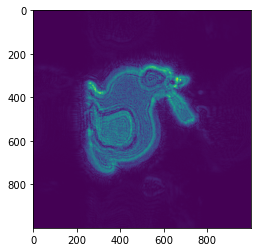

In [52]:
reconstruction = propagate_beam(
                                                hologram,
                                                k,
                                                -distance-0*diff,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )

plt.imshow(np.abs(reconstruction))

In [1]:
import numpy as np
import odak
from odak.wave import wavenumber,propagate_beam
import matplotlib.pyplot as plt
from multiplane import *

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import cv2

wavelength                 = 6.5*pow(10,-9)
pixeltom                   = 8*pow(10,-6)
k                          = (2*np.pi)/wavelength
distance = 0.15
propagation_type='Bandlimited Angular Spectrum'

sample_field = cv2.imread('illustration/david.jpeg', 0)
sample_field = padding(sample_field, margin_scale=3)

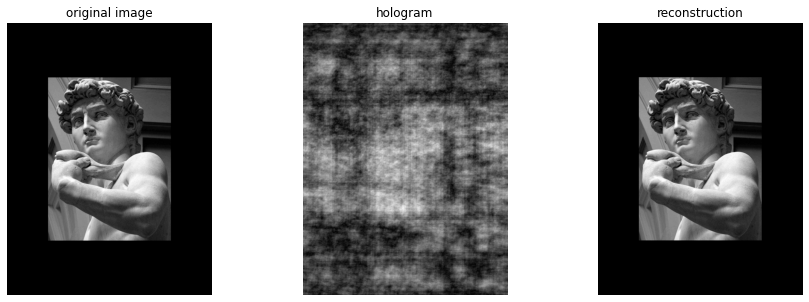

In [3]:
# type_list = ['IR Fresnel', 'TR Fresnel','Angular Spectrum', 'Bandlimited Angular Spectrum', 'Bandextended Angular Spectrum', 'Adaptive Sampling Angular Spectrum']
type_list = ['Bandlimited Angular Spectrum']

i = 1
plt.figure(figsize=(15, 5))
for propagation_type in type_list:
    hologram                  = propagate_beam(
                                                sample_field,
                                                k,
                                                distance,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )
    
    reconstruction             = propagate_beam(
                                                hologram,
                                                k,
                                                -distance,
                                                pixeltom,
                                                wavelength,
                                                propagation_type)
    plt.subplot(len(type_list),3,i)
    plt.axis('off')
    plt.title('original image')
    plt.imshow(np.abs(sample_field),cmap='gray')
    i+=1
    plt.subplot(len(type_list),3,i)
    plt.axis('off')
    plt.title('hologram')
    plt.imshow(np.abs(hologram),cmap='gray')
    i+=1
    plt.subplot(len(type_list),3,i)
    plt.axis('off')
    plt.title('reconstruction')
    plt.imshow(np.abs(reconstruction),cmap='gray')
    i+=1

plt.savefig(fname="david_propagation.jpeg")

In [2]:
# same amplitude different distance
wavelength                 = 6.5*pow(10,-7)
pixeltom                   = 6*pow(10,-6)
propagation_type           = 'Angular Spectrum'
k                          = wavenumber(wavelength)
distance = 0.15
diff = 0.04
hologram = np.zeros((1000,1000), dtype=np.complex64)
field = np.zeros((1000,1000), dtype=np.complex64)

subfield = np.zeros((1000,1000), dtype=np.complex64)
subfield[100:400,100:400] = 10
subfield[125:375, 125:375] = 0
random_phase = np.pi*np.random.random(subfield.shape)
subfield = subfield*np.cos(random_phase)+1j*subfield*np.sin(random_phase)
subhologram = propagate_beam(subfield,k,distance,pixeltom,wavelength,propagation_type)
field += subfield
hologram += subhologram

subfield = np.zeros((1000,1000), dtype=np.complex64)
subfield[100:400,600:900] = 10
subfield[125:375, 625:875] = 0
random_phase = np.pi*np.random.random(subfield.shape)
subfield = subfield*np.cos(random_phase)+1j*subfield*np.sin(random_phase)
subhologram = propagate_beam(subfield,k,distance+diff,pixeltom,wavelength,propagation_type)
field += subfield
hologram += subhologram

subfield = np.zeros((1000,1000), dtype=np.complex64)
subfield[600:900,100:400] = 10
subfield[625:875, 125:375] = 0
random_phase = np.pi*np.random.random(subfield.shape)
subfield = subfield*np.cos(random_phase)+1j*subfield*np.sin(random_phase)
subhologram = propagate_beam(subfield,k,distance+2*diff,pixeltom,wavelength,propagation_type)
field += subfield
hologram += subhologram

subfield = np.zeros((1000,1000), dtype=np.complex64)
subfield[600:900,600:900] = 10
subfield[625:875, 625:875] = 0
random_phase = np.pi*np.random.random(subfield.shape)
subfield = subfield*np.cos(random_phase)+1j*subfield*np.sin(random_phase)
subhologram = propagate_beam(subfield,k,distance+3*diff,pixeltom,wavelength,propagation_type)
field += subfield
hologram += subhologram



reconstruction = propagate_beam(
                                                hologram,
                                                k,
                                                -distance,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )

<ipython-input-3-645eabb92244>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname="sample_multilayer.jpeg",figsize=[15,20])


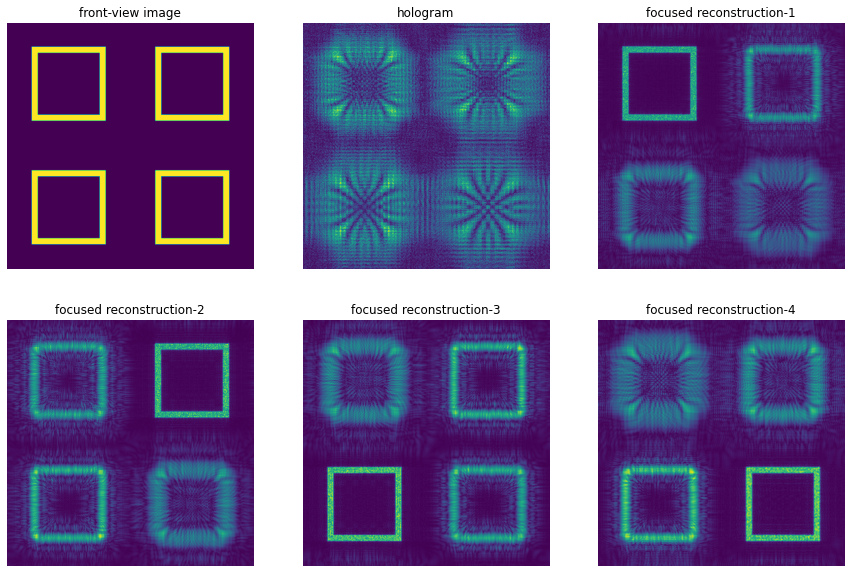

In [3]:
plt.figure(figsize=(15, 20))
plt.subplot(231), plt.axis('off'), plt.imshow(np.abs(field)), plt.title('front-view image')
plt.subplot(232), plt.axis('off'), plt.imshow(np.abs(hologram)), plt.title('hologram')
plt.subplot(233), plt.axis('off'), plt.imshow(np.abs(reconstruction)), plt.title('focused reconstruction-1')
plt.subplot(234), plt.axis('off'), plt.imshow(np.abs(propagate_beam(
                                                hologram,
                                                k,
                                                -distance-diff,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )))
plt.title('focused reconstruction-2')
plt.subplot(235), plt.axis('off'), plt.imshow(np.abs(propagate_beam(
                                                hologram,
                                                k,
                                                -distance-2*diff,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )))
plt.title('focused reconstruction-3')
plt.subplot(236), plt.axis('off'), plt.imshow(np.abs(propagate_beam(
                                                hologram,
                                                k,
                                                -distance-3*diff,
                                                pixeltom,
                                                wavelength,
                                                propagation_type
                                               )))
plt.title('focused reconstruction-4')
plt.savefig(fname="sample_multilayer.jpeg",figsize=[15,20])

In [1]:
import numpy as np
import open3d as o3d
from multiplane import *
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


phase-only test

In [4]:
import cv2
sample_field = cv2.imread('illustration/david.jpeg', 0)
sample_field = padding(sample_field, margin_scale=3)
hologram1 = propagate_beam(sample_field,(2*np.pi)/(650*1e-9), 0.15, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')

In [5]:
hol = Hologram(hologram1)
POH = hol.errorDiffusion()
hologram2 = POH

In [6]:
hologram1==hologram2
# top-right is the start point

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

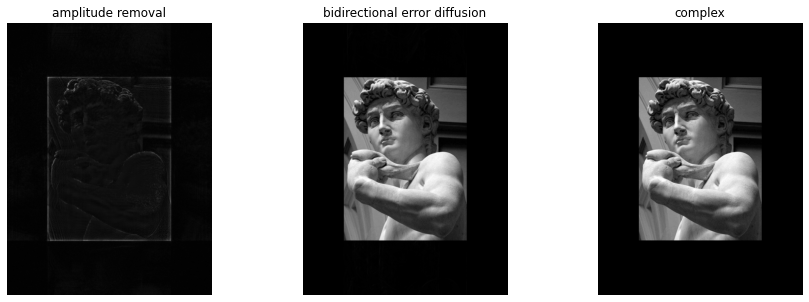

In [7]:
reconstruction1 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-0*0.0001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
reconstruction2 = propagate_beam(hologram2, (2*np.pi)/(650*1e-9), -0.15-0*0.0001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
reconstruction3 = propagate_beam(hologram1/np.abs(hologram1), (2*np.pi)/(650*1e-9), -0.15-0*0.0001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')

plt.figure(figsize=(15, 5))
plt.subplot(133), plt.imshow(np.abs(reconstruction1),cmap='gray'), plt.title('complex'), plt.axis('off')
plt.subplot(132), plt.imshow(np.abs(reconstruction2),cmap='gray'), plt.title('bidirectional error diffusion'), plt.axis('off')
plt.subplot(131), plt.imshow(np.abs(reconstruction3),cmap='gray'), plt.title('amplitude removal'), plt.axis('off')
plt.savefig(fname="complex_phase_only_comparison.jpeg")

In [1]:
points = np.asarray(o3d.io.read_point_cloud("data/bunny_pc.ply").points)
transform = Transform(points)
points = transform.rotation(np.pi*3/2, 2)
points = transform.rotation(np.pi, 0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


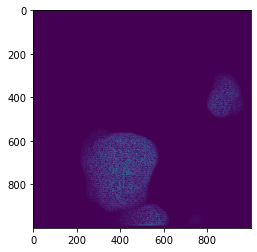

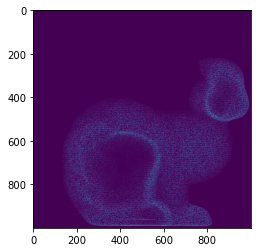

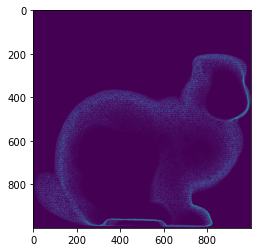

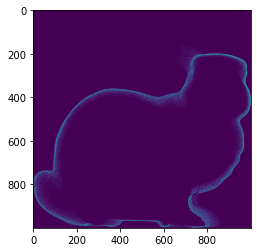

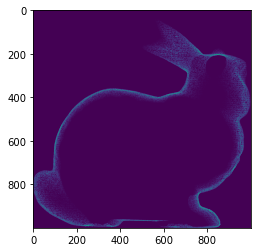

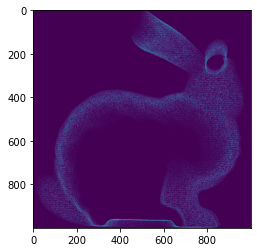

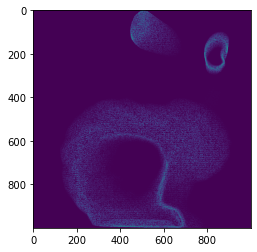

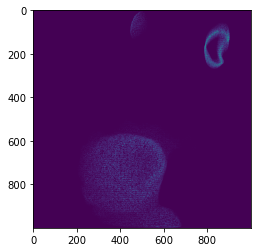

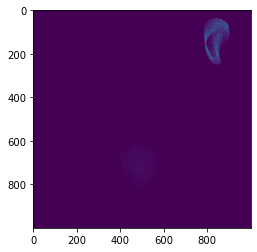

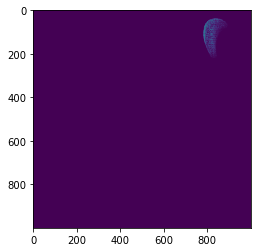

In [3]:
grid_list = multiLayerDF3D(points, 10, (1000,1000),keep_ratio=False)

for i, grid in enumerate(grid_list):
    plt.figure(i)
    plt.imshow(grid)

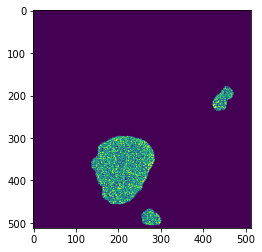

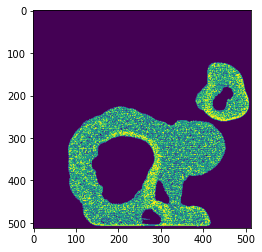

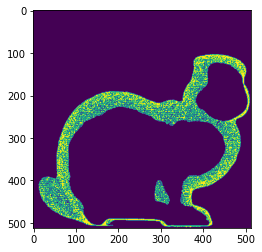

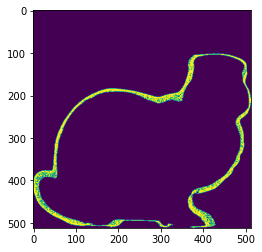

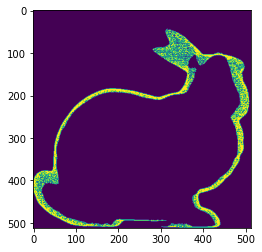

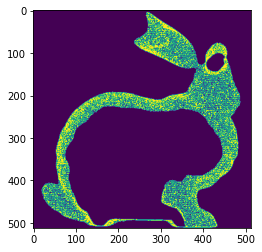

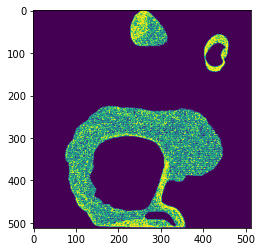

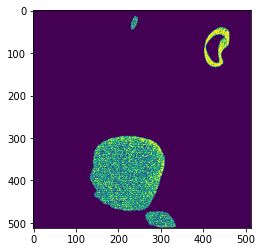

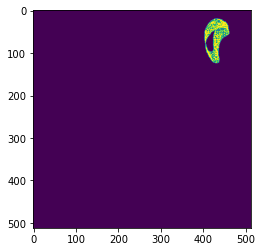

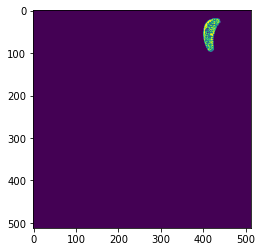

In [4]:
grid_list = multipleGrid(points, 10, (512,512), (1,1,1), keep_ratio=False)

for i, grid in enumerate(grid_list):
    plt.figure(i)
    plt.imshow(grid)

In [3]:
import time

In [4]:
times = []
for i in range(10): 
    start = time.time()

    hologram1 = layer_based_hologram(points, 50, [512,512], propagation_type='Bandlimited Angular Spectrum')
    
    times.append(time.time()-start)

np.average(times)    # print('encode time', time.time()-start, 's')

ready
ready
ready
ready
ready
ready
ready
ready
ready
ready


20.354400992393494

In [5]:
points.shape

(500000, 3)

In [2]:
mesh = o3d.io.read_triangle_mesh('data/park_chair.obj')
mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])   
    
pcd = mesh.sample_points_uniformly(number_of_points=10000000)
pcd.points = o3d.utility.Vector3dVector(normalize(np.array(pcd.points), 1, 1, 1))
#o3d.visualization.draw_geometries([pcd])
    
# input point cloud
points = np.array(pcd.points)

transform = Transform(points)
points = transform.rotation(np.pi*3/2, 2)
points = transform.rotation(7*np.pi/4, 0)

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D IN

In [3]:
hologram1 = layer_based_hologram(points, 150, [720,720], layer_dist=0.0001, propagation_type='Bandlimited Angular Spectrum')

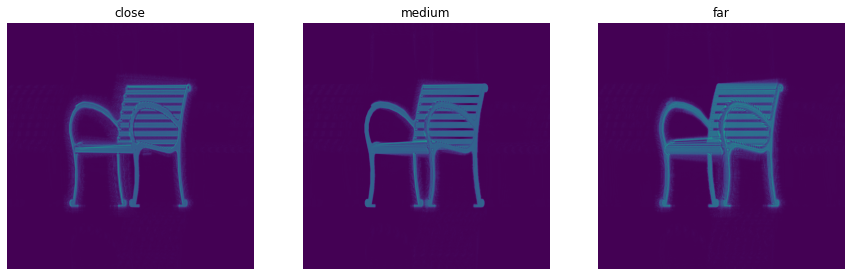

In [4]:
reconstruction1 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-0*0.00001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
reconstruction2 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-75*0.0001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
reconstruction3 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-150*0.0001, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(np.abs(reconstruction1)), plt.title('close'), plt.axis('off')
plt.subplot(132), plt.imshow(np.abs(reconstruction2)), plt.title('medium'), plt.axis('off')
plt.subplot(133), plt.imshow(np.abs(reconstruction3)), plt.title('far'), plt.axis('off')
plt.savefig(fname="different_focus.jpeg",bbox_inches='tight')

In [2]:
mesh = o3d.io.read_triangle_mesh('data/bunny.obj')
mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])   
    
pcd = mesh.sample_points_uniformly(number_of_points=10000000)
pcd.points = o3d.utility.Vector3dVector(normalize(np.array(pcd.points), 1, 1, 1))
#o3d.visualization.draw_geometries([pcd])

# input point cloud
points = np.array(pcd.points)

#points = np.asarray(o3d.io.read_point_cloud("data/bunny_pc.ply").points)
transform = Transform(points)
points = transform.rotation(np.pi*3/2, 2)
points = transform.rotation(np.pi*3/4, 0)
# ['IR Fresnel','TR Fresnel','Angular Spectrum', 'Bandlimited Angular Spectrum', 'Bandextended Angular Spectrum', 'Adaptive Sampling Angular Spectrum']

In [3]:
hologram1 = layer_based_hologram(points, 5, [720,720], layer_dist=0.004, propagation_type='Bandlimited Angular Spectrum')
reconstruction1 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-25*0.0003, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
hologram2 = layer_based_hologram(points, 100, [720,720], layer_dist=0.00012, propagation_type='Bandlimited Angular Spectrum')
reconstruction2 = propagate_beam(hologram2, (2*np.pi)/(650*1e-9), -0.15, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
hologram3 = layer_based_hologram(points, 250, [720,720], layer_dist=0.00004, propagation_type='Bandlimited Angular Spectrum')
reconstruction3 = propagate_beam(hologram3, (2*np.pi)/(650*1e-9), -0.15, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')

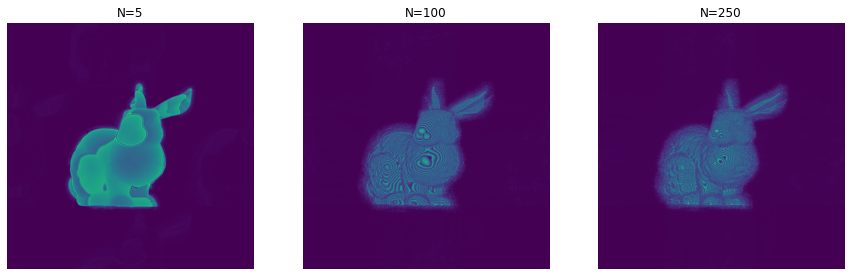

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(np.abs(reconstruction1)), plt.title('N=5'), plt.axis('off')
plt.subplot(132), plt.imshow(np.abs(reconstruction2)), plt.title('N=100'), plt.axis('off')
plt.subplot(133), plt.imshow(np.abs(reconstruction3)), plt.title('N=250'), plt.axis('off')
plt.savefig(fname="different_layernum.jpeg",bbox_inches='tight')

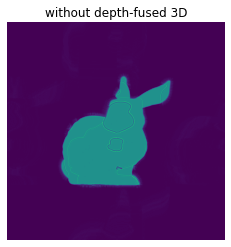

In [3]:
hologram1 = layer_based_hologram(points, 5, [720,720], layer_dist=0.004, propagation_type='Bandlimited Angular Spectrum',df3d=False)
reconstruction1 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-25*0.0003, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
plt.imshow(np.abs(reconstruction1)), plt.title('without depth-fused 3D'), plt.axis('off')
plt.savefig(fname="without_df3d.jpeg",bbox_inches='tight')

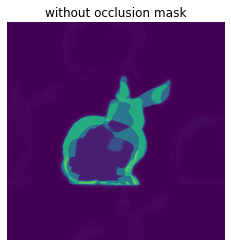

In [3]:
hologram1 = layer_based_hologram(points, 5, [720,720], layer_dist=0.004, propagation_type='Bandlimited Angular Spectrum',df3d=False)
reconstruction1 = propagate_beam(hologram1, (2*np.pi)/(650*1e-9), -0.15-25*0.0003, 8e-06, 650*1e-9, 'Bandlimited Angular Spectrum')
plt.imshow(np.abs(reconstruction1)), plt.title('without occlusion mask'), plt.axis('off')
plt.savefig(fname="without_occlusion.jpeg",bbox_inches='tight')